# Fuente: Plataforma digital de datos abiertos (datos.gob.mx) | CSV: Transacciones de combustibles 2024    (CC by 4.0)

### Objetivo: Analizar la variacion temporal del precio de distintas gasolinas.

In [30]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

t1 = time.time()
data = pd.read_csv('Historico_Precios_Expendios.csv_2024.csv')
t2 = time.time()


print(f'read_csv() tomó: {t2-t1} segundos')
print(data.sample(20)) 


read_csv() tomó: 9.441295862197876 segundos
                 numeropermiso        subproducto       fecha  precio
7351963    PL/3563/EXP/ES/2015            Premium  2024-05-01   25.58
5825405   PL/24912/EXP/ES/2023            Regular  2024-05-29     NaN
11670721    PL/777/EXP/ES/2015            Premium  2024-03-20   24.77
4128279   PL/21613/EXP/ES/2018            Regular  2024-06-14   22.69
6743638    PL/2962/EXP/ES/2015  Diésel Automotríz  2024-03-29   24.89
4428461   PL/22372/EXP/ES/2019            Regular  2024-08-15   23.69
4263891   PL/21897/EXP/ES/2018            Regular  2024-12-23     NaN
6353577   PL/26009/EXP/ES/2024            Regular  2024-07-02     NaN
5098867   PL/23787/EXP/ES/2021            Premium  2024-05-01   23.71
1990688   PL/13136/EXP/ES/2016            Regular  2024-01-15     NaN
7870008    PL/4040/EXP/ES/2015            Regular  2024-10-03   23.99
8065093    PL/4224/EXP/ES/2015            Regular  2024-10-10   23.49
2583581    PL/1756/EXP/ES/2015            Regu

## (EDA) Exploración analítica de datos

En esta parte se intenta encontrar las tendencias en los datos, en este caso podemos hacernos varias preguntas acerca del precio, pues tenemos el registro de cada transacción con. 

- ¿Cómo varía el precio a lo largo del año?
- ¿Qué tanto varía el precio de las gasolinas?
- ¿Cuántas transacciones por gasolina hay?

### 1. Comenzamos describiendo la información.
Los datos disponibles incluyen los siguientes campos:

- Fecha: en formato yy-mm--dd.
- Número de permiso: el número de permiso es un número que se otrorga a cada concesión.
- Subproducto: los distintos subproductos del crudo que se venden como gasolinas.
- Precio: precio por litro.

In [34]:
#hay varios registros en los que no se reporta el precio, pero no creo aún que se deban tirar,
#debido a la informacion que implica numero de permiso
#data.describe(include='all') alternativa rápida. 
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13771848 entries, 0 to 13771847
Data columns (total 4 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   numeropermiso  13771848 non-null  object 
 1   subproducto    13771848 non-null  object 
 2   fecha          13771848 non-null  object 
 3   precio         8410878 non-null   float64
dtypes: float64(1), object(3)
memory usage: 420.3+ MB


In [35]:
#nos preguntamos por el número de gasolinas distintas que se toman en cuenta.
categories = pd.unique(data['subproducto'])
print(f'-Hay {len(categories)} tipos de gasolina.') 
print(f'-Los subproductos registrados son: {categories}')

#igual el numero de permisos
permisos = pd.unique(data['numeropermiso'])
print(f'-Hay {len(permisos)} permisos.')

#convertimos fecha a datetime
data.fecha = pd.to_datetime(data['fecha'])

print('El precio falta en la mitad de los registros')

-Hay 6 tipos de gasolina.
-Los subproductos registrados son: ['Diésel Automotríz' 'Premium' 'Regular'
 'Diésel de Ultra Bajo Azufre (DUBA)' 'Diésel Agrícola/Marino'
 'Diésel Industrial']
-Hay 13785 permisos.
El precio falta en la mitad de los registros


### **2. Se calcula el costo promedio de cada gasolina en 2024**
A pesar de cualquier tendencia en periodos más cortos que pueda haber en el precio, está cantidad indica la observación anual, para ello debemos promediar los precios indexando cada registro por 'subproducto' y aggregando el precio en un promedio, una manera de resumir los datos es con pivot_table(), podemos concluir que **nunca** se reporta el precio para 'Diesel Industrial'.

<AxesSubplot:title={'center':'Costo promedio en 2024'}, ylabel='subproducto'>

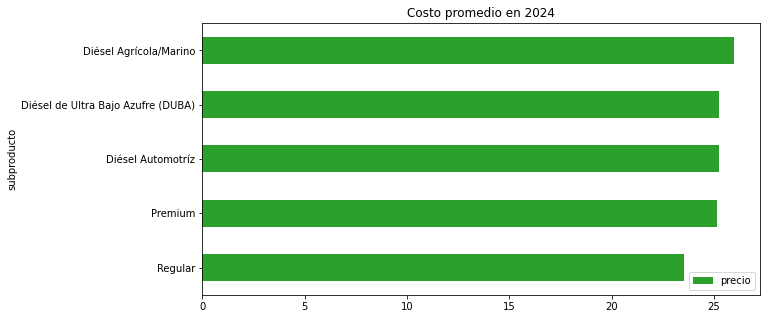

In [36]:
subp = data.pivot_table('precio', columns='subproducto', aggfunc='mean')
sub= subp.T
sub= sub.sort_values(by='precio')
sub.plot(title='Costo promedio en 2024', kind='barh', color = 'C2', figsize = (10,5))

### 3. Se obtiene el precio de cada combustible a lo largo del año:

1. **Filtrar** las filas del arreglo original con lista de categorías para enfocarnos en cada combustible.
2. Ordenar temporalmente por la columna 'fecha', la opcion más *directa* es **separar** 'fecha' en tres columnas (o dos), la segunda opción es aprovechar el unicode pues en python debe funcionar la comparación de cada fecha con el operador > y simplemete usar el método sort_values() como anteriormente se hizo, la tercera opcion es darse cuenta que ya esta ordenadas por fecha por que así se generan los datos.
3. El problema es que hay muchos tipos de permiso, como vimos en la exploración, por lo que se deben **agrupar** los registros por fecha, elegimos promediar, aunque eso oscurece cuánto varía el precio en cada permiso cada día.

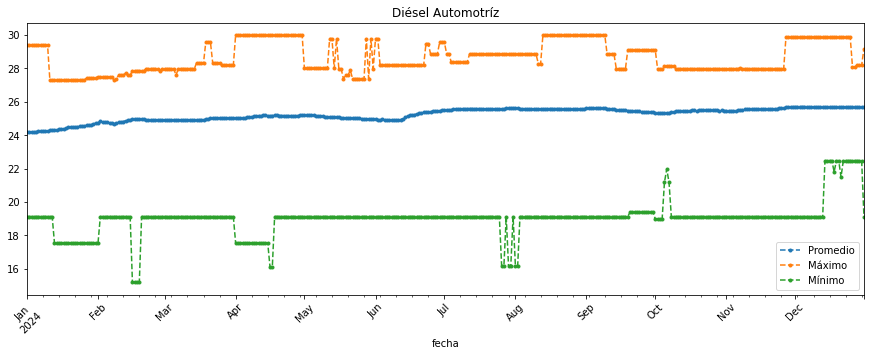

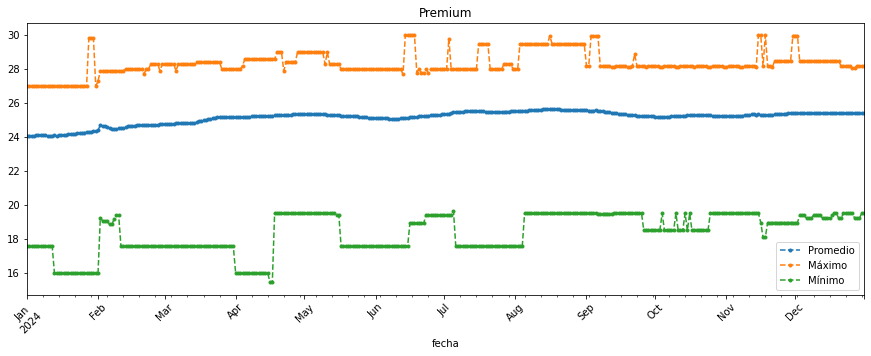

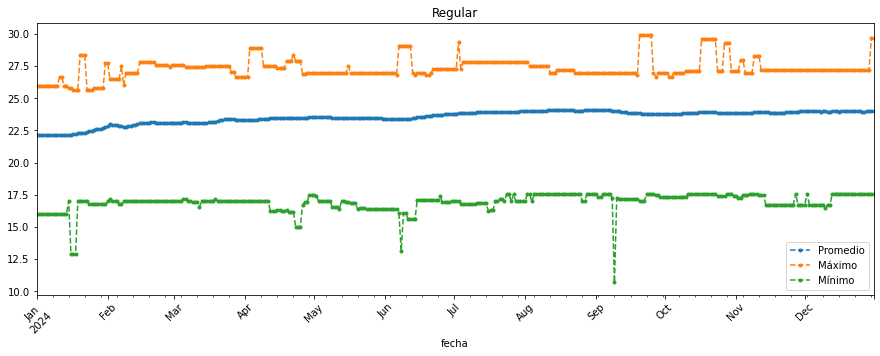

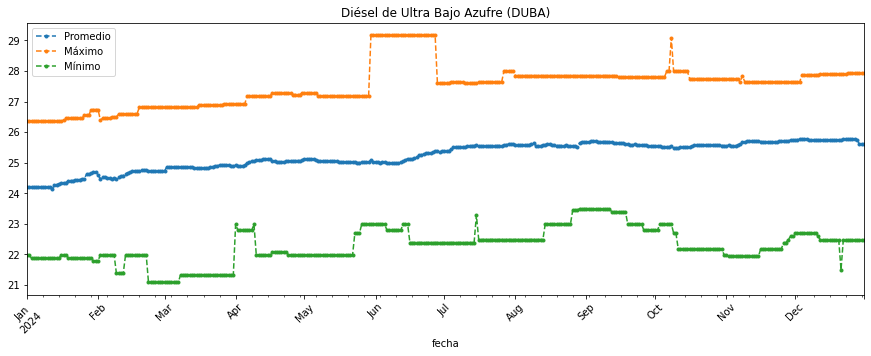

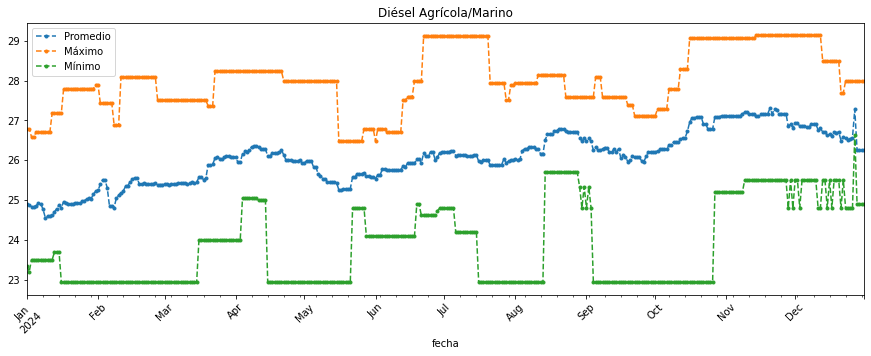

In [38]:
%matplotlib inline

#Omitimos los valores faltantes.
categories = categories[categories!='Diésel Industrial']
data=data.dropna()

ldf = []
j=0
for i in categories:

    res = data[data.subproducto == i]
    dummy = res['precio'].groupby(data['fecha'])
    
    
    means = dummy.agg('mean') #obtener: promedio, mínimo y máximo
    means.name = 'Promedio' #cambio en el nombre del dataframe
    
    sup = dummy.agg('max')
    sup.name = 'Máximo'
    
    inf = dummy.agg('min')
    inf.name = 'Mínimo'
    
    #pandas puede presentar todas las líneas de un dataframe, 
    precio_anual = pd.concat([means,sup,inf], axis=1)
    precio_anual.plot(kind='line',rot=45,title=i,figsize=(15,5),style='.--') 


# Conclusiones
1. Todas las curvas promedio presentan un mínimo local a mediados de mayo, se debe observar la correlación de los promedios.El rango de precio por día de cada combustible varía aproximadamente 10 pesos dado cualquier día, ~50 %.
2. Todas las curvas promedio presentan un mínimo local a mediados de mayo, se debe observar la correlación de los promedios.
3. Las regiones de los mínimos y los máximos son constantes a lo largo del año.

### Trabajo por hacer: 
1. Regresión para los promedios, acompañada de intervalos de 'confianza' para indicar la distribución por día (así poder pedecir precios).
2. Correlación para los distintos subproductos: promedio-máximo-mínimo.
3. Una vez establecida una correlación positiva, podemos: restar el promedio de cada precio por día y con todos los  datos calcular una medida de la dispersión, esto significa que a pesar de la diferencia del máximo, sospecho, la mayoría de las transacciones son cercanas al promedio.